In [58]:
import pandas as pd
import os
from tqdm import tqdm

# Define the directory where your CSV files are located
folder_path = "/Users/marclambertes/Python/Matches/Men/2024-2025/Eredivisie 2024-2025/"  # Replace with your folder path
output_file = "Eredivisie Coach 2024-2025.xlsx"  # Output file path

# Define goalkeeper-related actions
gk_actions = {
    'Goalkick': 124,
    'GK throw': 123,
    'Parried Safe': 173,
    'Parried Danger': 174,
    'Fingertip': 175,
    'Caught': 176,
    'Collected': 177,
    'Standing Goalkeeper': 178,
    'Diving': 179,
    'Stooping': 180,
    'Reaching': 181,
    'Hands': 182,
    'Feet': 183,
    'Scored': 186,
    'Saved': 187,
    'Missed': 188
}

# Create a list to store all results
all_results = []

# Loop through all CSV files in the folder
for file_name in tqdm(os.listdir(folder_path), desc="Processing Files"):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        
        # Read the CSV file
        df = pd.read_csv(file_path)

        # Identify columns with '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Initialize 'endX' and 'endY' columns
        df['endX'] = 0.0
        df['endY'] = 0.0

        # Map qualifierId to corresponding value columns
        qualifier_value_cols = {int(col.split('/')[1]): col for col in df.columns if 'qualifier' in col and 'value' in col}

        # Process rows efficiently
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows"):
            for j, type_col in enumerate(type_cols):
                if row[type_col] == 140:
                    endx_col = qualifier_value_cols.get(j)
                    if endx_col:
                        df.at[index, 'endX'] = row[endx_col]
                elif row[type_col] == 141:
                    endy_col = qualifier_value_cols.get(j)
                    if endy_col:
                        df.at[index, 'endY'] = row[endy_col]

        # Initialize new columns for different types of set pieces
        df['Set Piece'] = 0
        df['From Corner'] = 0
        df['Free Kick'] = 0
        df['Throw In'] = 0

        # Process rows efficiently to flag set pieces
        for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Rows for Set Pieces"):
            for j, type_col in enumerate(type_cols):
                qualifier = row[type_col]
                
                # Check for the 'qualifierId' values
                if qualifier == 24:
                    df.at[index, 'Set Piece'] = 1
                elif qualifier == 25:
                    df.at[index, 'From Corner'] = 1
                elif qualifier == 26:
                    df.at[index, 'Free Kick'] = 1
                elif qualifier == 160:
                    df.at[index, 'Throw In'] = 1

        # Now assign Set Piece metric for the rows where 'Set Piece' is true or 'From Corner' or 'Free Kick' or 'Throw In'
        df['Set Piece'] = df.apply(
            lambda row: 1 if row['typeId'] in [13, 14, 15, 16] and 
                        (row['Set Piece'] == 1 or row['From Corner'] == 1 or 
                         row['Free Kick'] == 1 or row['Throw In'] == 1) else 0,
            axis=1
        )

        # Convert columns to numeric
        df[['x', 'y', 'endX', 'endY']] = df[['x', 'y', 'endX', 'endY']].apply(pd.to_numeric, errors='coerce')

        # Define event-based metrics
        df_long_balls = df[(df['typeId'] == 1) & (df['x'] < 30) & (df['endX'] > 50)]
        df_deep_circulations = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & (df['endX'].between(30, 60))]
        df_wing_play = df[(df['typeId'] == 1) & (df['x'].between(30, 60)) & (df['y'].between(22, 78)) & ((df['endY'] < 22) | (df['endY'] > 78))]
        df_final_third = df[(df['typeId'] == 1) & (df['x'] > 70)]
        df_crossing = df[(df['typeId'] == 1) & (df['x'] > 50) & ((df['y'] <= 22) | (df['y'] >= 78)) & (df['endY'].between(22, 78)) & (df['endX'] > 85)]
        df_opposition_passes = df[df['typeId'] == 1]
        df_defensive_actions = df[df['typeId'].isin([7, 8])]

        # Aggregate counts
        long_balls_count = df_long_balls.groupby('contestantId').size().reset_index(name='Long balls')
        deep_circulations_count = df_deep_circulations.groupby('contestantId').size().reset_index(name='Deep circulation')
        wing_play_count = df_wing_play.groupby('contestantId').size().reset_index(name='Wing play')
        final_third_count = df_final_third.groupby('contestantId').size().reset_index(name='Final third passes')
        crossing_count = df_crossing.groupby('contestantId').size().reset_index(name='Crossing')

        # Territory calculation
        total_final_third_passes = df_final_third.shape[0]
        final_third_count['Territory'] = (final_third_count['Final third passes'] / total_final_third_passes) * 100

        # Low Block calculation
        df['Low Block'] = df.apply(lambda row: 1 if row['typeId'] in [7, 8, 12] and row['x'] < 25 else 0, axis=1)
        total_defensive_actions = df[df['typeId'].isin([7, 8, 12])].shape[0]
        low_block_count = df.groupby('contestantId')['Low Block'].sum().reset_index()
        low_block_count['Low Block'] = (low_block_count['Low Block'] / total_defensive_actions) * 100

        # Counters calculation
        def find_counters(df):
            counters = []
            for i in range(len(df)):
                if df.iloc[i]['typeId'] == 49 and df.iloc[i]['x'] < 50:
                    found_counter = any(df.iloc[j]['typeId'] == 1 and df.iloc[j]['x'] > 70 for j in range(i + 1, min(i + 4, len(df))))
                    counters.append(1 if found_counter else 0)
                else:
                    counters.append(0)
            return counters

        df['Counters'] = find_counters(df)
        counters_count = df.groupby('contestantId')['Counters'].sum().reset_index()

        # Set Piece calculation (already done above for each row)

        # Merge all metrics into the final result
        result = long_balls_count.merge(deep_circulations_count, on='contestantId', how='left').fillna(0)
        result = result.merge(wing_play_count, on='contestantId', how='left').fillna(0)
        result = result.merge(final_third_count[['contestantId', 'Territory']], on='contestantId', how='left').fillna(0)
        result = result.merge(crossing_count, on='contestantId', how='left').fillna(0)
        result = result.merge(low_block_count, on='contestantId', how='left').fillna(0)
        result = result.merge(counters_count, on='contestantId', how='left').fillna(0)
        result = result.merge(df.groupby('contestantId')['Set Piece'].sum().reset_index(), on='contestantId', how='left').fillna(0)

        # High Press calculation
        total_opposition_passes = df_opposition_passes.shape[0]
        result['High Press'] = result.apply(lambda row: (total_opposition_passes - row.get('Opposition passes', 0)) / row.get('Defensive actions', 1), axis=1)

        # Ensure integer types
        int_cols = ['Long balls', 'Deep circulation', 'Wing play', 'Crossing', 'Counters', 'Set Piece']
        result[int_cols] = result[int_cols].astype(int)

        # --- Step for Goalkeeper Actions ---
        # Add GK action columns (default 0)
        for action in gk_actions.keys():
            df[action] = 0

        # Identify type columns containing '/qualifierId'
        type_cols = [col for col in df.columns if '/qualifierId' in col]

        # Step 1: Identify goalkeepers based on specific qualifiers
        for i in range(len(df)):
            for col in type_cols:
                qualifier_value = df.at[i, col]
                for action, value in gk_actions.items():
                    if qualifier_value == value:
                        df.at[i, action] = 1

        # Step 2: Calculate GK action count per player
        df['GK_Action_Count'] = df[list(gk_actions.keys())].sum(axis=1)

        # Step 3: Identify one goalkeeper per contestantId (team)
        gk_candidates = df.groupby(['contestantId', 'playerName'])['GK_Action_Count'].sum().reset_index()
        gk_best_per_team = gk_candidates.sort_values(['contestantId', 'GK_Action_Count'], ascending=[True, False])
        gk_best_per_team = gk_best_per_team.groupby('contestantId').first().reset_index()

        # Step 4: Merge with main df to get all passes (typeId == 1) for selected GKs
        gk_passes = df.merge(gk_best_per_team, on=['contestantId', 'playerName'], how='inner')
        gk_passes = gk_passes[gk_passes['typeId'] == 1]

        # Step 5: Count passes per GK per contestantId
        gk_pass_count = gk_passes.groupby(['contestantId', 'playerName']).size().reset_index(name='Pass_Count')

        # Step 6: Calculate the total number of passes in the dataset
        total_passes = len(df[df['typeId'] == 1])

        # Step 7: Calculate the percentage of passes made by each goalkeeper (now renamed to GK Build Up)
        gk_pass_count['GK Build Up'] = (gk_pass_count['Pass_Count'] / total_passes) * 100

        # Merge goalkeeper stats into the final result
        result = result.merge(gk_pass_count[['contestantId', 'playerName', 'Pass_Count', 'GK Build Up']], 
                              on='contestantId', how='left')

        all_results.append(result)

# Combine all results
final_result = pd.concat(all_results, ignore_index=True)

# Calculate per-contestant averages
averages_per_contestant = final_result.groupby('contestantId').mean()

# Save to Excel
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, sheet_name='Aggregated Data', index=False)
    averages_per_contestant.to_excel(writer, sheet_name='Averages per Contestant', index=True)

print(f"Processing completed. Results saved to {output_file}.")


Processing Rows: 100%|████████████████████| 1856/1856 [00:00<00:00, 2899.85it/s]

Processing Rows: 100%|████████████████████| 1790/1790 [00:00<00:00, 3700.42it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 3649.49it/s]

Processing Rows: 100%|████████████████████| 1827/1827 [00:00<00:00, 1952.62it/s]

Processing Rows: 100%|████████████████████| 1505/1505 [00:00<00:00, 4097.13it/s]

Processing Rows: 100%|████████████████████| 1683/1683 [00:00<00:00, 2911.81it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 2640.52it/s]

Processing Rows: 100%|████████████████████| 1704/1704 [00:00<00:00, 3231.83it/s]

Processing Rows: 100%|████████████████████| 1839/1839 [00:00<00:00, 2899.83it/s]

Processing Rows for Set Pieces: 100%|█████| 1839/1839 [00:00<00:00, 6144.01it/s]


Processing Rows: 100%|████████████████████| 1615/1615 [00:00<00:00, 3307.34it/s]

Processing Rows: 100%|████████████████████| 1671/1671 [00:00<00:00, 4240.46it/s]

Processing Rows: 100%|████████████████████| 1770/1770 [00:00<00:00, 3504.43it/s]

Processing Rows: 100%|████████████████████| 1732/1732 [00:00<00:00, 4088.80it/s]

Processing Rows: 100%|████████████████████| 1712/1712 [00:00<00:00, 4271.46it/s]

Processing Rows: 100%|████████████████████| 1767/1767 [00:00<00:00, 3408.04it/s]

Processing Rows: 100%|████████████████████| 1638/1638 [00:00<00:00, 4549.05it/s]

Processing Rows: 100%|████████████████████| 1860/1860 [00:00<00:00, 3733.67it/s]

Processing Rows: 100%|████████████████████| 1716/1716 [00:00<00:00, 3546.05it/s]

Processing Rows: 100%|████████████████████| 1831/1831 [00:00<00:00, 4035.87it/s]

Processing Rows: 100%|████████████████████| 1753/1753 [00:00<00:00, 3942.12it/s]

Processing Rows for Set Pieces:  38%|██▎   | 672/1753 [00:00<00:00, 6716.31it/s]


Processing Rows: 100%|████████████████████| 1734/1734 [00:00<00:00, 3481.23it/s]

Processing Rows: 100%|████████████████████| 1856/1856 [00:00<00:00, 3626.10it/s]

Processing Rows: 100%|████████████████████| 1655/1655 [00:00<00:00, 3294.78it/s]

Processing Rows: 100%|████████████████████| 1753/1753 [00:00<00:00, 2314.41it/s]

Processing Rows: 100%|████████████████████| 1889/1889 [00:00<00:00, 3741.75it/s]

Processing Rows: 100%|████████████████████| 1843/1843 [00:00<00:00, 3933.37it/s]

Processing Rows: 100%|████████████████████| 1675/1675 [00:00<00:00, 4020.09it/s]

Processing Rows: 100%|████████████████████| 1682/1682 [00:00<00:00, 3701.59it/s]

Processing Rows: 100%|████████████████████| 1818/1818 [00:00<00:00, 3353.61it/s]

Processing Rows: 100%|████████████████████| 1800/1800 [00:00<00:00, 3615.62it/s]

Processing Files:  15%|███▋                    | 30/195 [00:48<04:26,  1.61s/it]


Processing Rows: 100%|████████████████████| 1824/1824 [00:00<00:00, 2476.51it/s]

Processing Rows: 100%|████████████████████| 1753/1753 [00:00<00:00, 3556.26it/s]

Processing Rows: 100%|████████████████████| 1800/1800 [00:00<00:00, 3927.52it/s]

Processing Rows: 100%|████████████████████| 1744/1744 [00:00<00:00, 2578.36it/s]

Processing Rows: 100%|████████████████████| 1760/1760 [00:00<00:00, 2450.01it/s]

Processing Rows: 100%|████████████████████| 1877/1877 [00:00<00:00, 3160.41it/s]

Processing Rows: 100%|████████████████████| 1748/1748 [00:00<00:00, 2324.30it/s]

Processing Rows: 100%|████████████████████| 1776/1776 [00:00<00:00, 2847.07it/s]

Processing Rows: 100%|████████████████████| 1679/1679 [00:00<00:00, 2855.09it/s]

Processing Rows:   0%|                                 | 0/1909 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1909/1909 [00:00<00:00, 3210.92it/s]

Processing Rows: 100%|████████████████████| 1798/1798 [00:00<00:00, 2721.31it/s]

Processing Rows: 100%|████████████████████| 1600/1600 [00:00<00:00, 2798.57it/s]

Processing Rows: 100%|████████████████████| 1887/1887 [00:00<00:00, 2053.66it/s]

Processing Rows: 100%|████████████████████| 1886/1886 [00:00<00:00, 2564.64it/s]

Processing Rows: 100%|████████████████████| 1803/1803 [00:00<00:00, 3573.34it/s]

Processing Rows: 100%|████████████████████| 1758/1758 [00:00<00:00, 3741.45it/s]

Processing Rows: 100%|████████████████████| 1778/1778 [00:00<00:00, 3151.44it/s]

Processing Rows:  59%|███████████▊        | 1060/1799 [00:00<00:00, 2637.76it/s]


Processing Rows: 100%|████████████████████| 1799/1799 [00:00<00:00, 2260.85it/s]

Processing Rows: 100%|████████████████████| 1532/1532 [00:00<00:00, 3096.34it/s]

Processing Rows: 100%|████████████████████| 1760/1760 [00:00<00:00, 3631.94it/s]

Processing Rows: 100%|████████████████████| 1802/1802 [00:01<00:00, 1420.16it/s]

Processing Rows: 100%|████████████████████| 1626/1626 [00:00<00:00, 4062.04it/s]

Processing Rows: 100%|████████████████████| 1843/1843 [00:00<00:00, 4035.79it/s]

Processing Rows: 100%|████████████████████| 1582/1582 [00:00<00:00, 3491.85it/s]

Processing Rows: 100%|████████████████████| 1617/1617 [00:00<00:00, 3972.09it/s]

Processing Rows: 100%|████████████████████| 1708/1708 [00:00<00:00, 3408.93it/s]

Processing Rows: 100%|████████████████████| 1890/1890 [00:01<00:00, 1776.87it/s]

Processing Rows for Set Pieces:   0%|                  | 0/1890 [00:00<?, ?it/s]


Processing Rows: 100%|████████████████████| 1696/1696 [00:00<00:00, 3903.78it/s]

Processing Rows: 100%|████████████████████| 1706/1706 [00:00<00:00, 5184.73it/s]

Processing Rows: 100%|████████████████████| 1671/1671 [00:00<00:00, 5106.84it/s]

Processing Rows: 100%|████████████████████| 1585/1585 [00:00<00:00, 5349.07it/s]

Processing Rows: 100%|████████████████████| 1754/1754 [00:00<00:00, 5917.56it/s]

Processing Rows: 100%|████████████████████| 1712/1712 [00:00<00:00, 5054.37it/s]

Processing Rows: 100%|████████████████████| 1762/1762 [00:00<00:00, 5627.67it/s]

Processing Rows: 100%|████████████████████| 1714/1714 [00:00<00:00, 5347.16it/s]

Processing Rows: 100%|████████████████████| 1944/1944 [00:00<00:00, 5067.31it/s]

Processing Rows: 100%|████████████████████| 1656/1656 [00:00<00:00, 5337.52it/s]

Processing Rows: 100%|████████████████████| 1919/1919 [00:00<00:00, 4205.18it/s]

Processing Rows: 100%|████████████████████| 1661/1661 [00:00<00:00, 3850.76it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1921/1921 [00:00<00:00, 4099.97it/s]

Processing Rows: 100%|████████████████████| 1800/1800 [00:00<00:00, 3964.02it/s]

Processing Rows: 100%|████████████████████| 1712/1712 [00:00<00:00, 5773.21it/s]

Processing Rows: 100%|████████████████████| 1719/1719 [00:00<00:00, 4867.37it/s]

Processing Rows: 100%|████████████████████| 1612/1612 [00:01<00:00, 1443.99it/s]

Processing Rows: 100%|████████████████████| 1787/1787 [00:00<00:00, 3813.89it/s]

Processing Rows: 100%|████████████████████| 1744/1744 [00:00<00:00, 5108.30it/s]

Processing Rows: 100%|████████████████████| 1643/1643 [00:00<00:00, 5139.10it/s]

Processing Rows: 100%|████████████████████| 1663/1663 [00:00<00:00, 4827.27it/s]

Processing Rows: 100%|████████████████████| 1756/1756 [00:00<00:00, 4026.67it/s]

Processing Rows: 100%|████████████████████| 1637/1637 [00:00<00:00, 4898.43it/s]

Processing Rows: 100%|████████████████████| 1835/1835 [00:00<00:00, 5643.74it/s]



Processing Rows: 100%|████████████████████| 1660/1660 [00:00<00:00, 4887.22it/s]

Processing Rows: 100%|████████████████████| 1632/1632 [00:00<00:00, 4308.87it/s]

Processing Rows: 100%|████████████████████| 1725/1725 [00:00<00:00, 4977.98it/s]

Processing Rows: 100%|████████████████████| 1736/1736 [00:00<00:00, 5333.01it/s]

Processing Rows: 100%|████████████████████| 1697/1697 [00:00<00:00, 3218.33it/s]

Processing Rows: 100%|████████████████████| 1811/1811 [00:00<00:00, 6098.34it/s]

Processing Rows: 100%|████████████████████| 1576/1576 [00:00<00:00, 4855.91it/s]

Processing Rows: 100%|████████████████████| 1739/1739 [00:00<00:00, 3177.49it/s]

Processing Rows: 100%|████████████████████| 1533/1533 [00:00<00:00, 2802.83it/s]

Processing Rows: 100%|████████████████████| 1850/1850 [00:00<00:00, 3716.48it/s]

Processing Rows: 100%|████████████████████| 1791/1791 [00:00<00:00, 3507.44it/s]

Processing Rows:  53%|███████████          | 899/1708 [00:00<00:00, 4508.71it/s]


Processing Rows: 100%|████████████████████| 1708/1708 [00:00<00:00, 4470.65it/s]

Processing Rows: 100%|████████████████████| 1817/1817 [00:00<00:00, 3647.14it/s]

Processing Rows: 100%|████████████████████| 1753/1753 [00:00<00:00, 4434.32it/s]

Processing Rows: 100%|████████████████████| 1903/1903 [00:00<00:00, 2232.53it/s]

Processing Rows: 100%|████████████████████| 1800/1800 [00:00<00:00, 4842.17it/s]

Processing Rows: 100%|████████████████████| 1696/1696 [00:00<00:00, 5103.41it/s]

Processing Rows: 100%|████████████████████| 1548/1548 [00:00<00:00, 5124.17it/s]

Processing Rows: 100%|████████████████████| 1669/1669 [00:00<00:00, 4232.20it/s]

Processing Rows: 100%|████████████████████| 1853/1853 [00:00<00:00, 5981.47it/s]

Processing Rows: 100%|████████████████████| 1703/1703 [00:00<00:00, 4258.33it/s]

Processing Rows: 100%|████████████████████| 1747/1747 [00:00<00:00, 4456.69it/s]

Processing Rows: 100%|████████████████████| 1671/1671 [00:00<00:00, 4039.86it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1726/1726 [00:00<00:00, 3424.79it/s]

Processing Rows: 100%|████████████████████| 1789/1789 [00:00<00:00, 5215.35it/s]

Processing Rows: 100%|████████████████████| 1782/1782 [00:00<00:00, 2777.02it/s]

Processing Rows: 100%|████████████████████| 1709/1709 [00:00<00:00, 4827.31it/s]

Processing Rows: 100%|████████████████████| 1759/1759 [00:00<00:00, 5293.65it/s]

Processing Rows: 100%|████████████████████| 1595/1595 [00:00<00:00, 4734.51it/s]

Processing Rows: 100%|████████████████████| 1775/1775 [00:00<00:00, 6280.52it/s]

Processing Rows: 100%|████████████████████| 1673/1673 [00:00<00:00, 5289.28it/s]

Processing Rows: 100%|████████████████████| 1717/1717 [00:00<00:00, 4702.81it/s]

Processing Rows: 100%|████████████████████| 1753/1753 [00:00<00:00, 4594.36it/s]

Processing Rows: 100%|████████████████████| 1786/1786 [00:00<00:00, 4860.89it/s]

Processing Rows: 100%|████████████████████| 1692/1692 [00:00<00:00, 1710.94it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1681/1681 [00:00<00:00, 4808.98it/s]

Processing Rows: 100%|████████████████████| 1778/1778 [00:00<00:00, 5268.46it/s]

Processing Rows: 100%|████████████████████| 1846/1846 [00:00<00:00, 3140.73it/s]

Processing Rows: 100%|████████████████████| 1733/1733 [00:00<00:00, 4837.78it/s]

Processing Rows: 100%|████████████████████| 1732/1732 [00:00<00:00, 4626.83it/s]

Processing Rows: 100%|████████████████████| 1769/1769 [00:00<00:00, 3342.86it/s]

Processing Rows: 100%|████████████████████| 1594/1594 [00:00<00:00, 4110.91it/s]

Processing Rows: 100%|████████████████████| 1737/1737 [00:00<00:00, 3647.10it/s]

Processing Rows: 100%|████████████████████| 1814/1814 [00:00<00:00, 3856.28it/s]

Processing Rows: 100%|████████████████████| 1791/1791 [00:00<00:00, 5123.82it/s]

Processing Rows: 100%|████████████████████| 1631/1631 [00:00<00:00, 4934.29it/s]

Processing Rows:  15%|███▎                 | 287/1854 [00:00<00:00, 2860.18it/s]


Processing Rows: 100%|████████████████████| 1854/1854 [00:00<00:00, 4030.77it/s]

Processing Rows: 100%|████████████████████| 1727/1727 [00:00<00:00, 3801.84it/s]

Processing Rows: 100%|████████████████████| 1809/1809 [00:00<00:00, 4920.64it/s]

Processing Rows: 100%|████████████████████| 1756/1756 [00:00<00:00, 4572.98it/s]

Processing Rows: 100%|████████████████████| 1726/1726 [00:00<00:00, 4779.68it/s]

Processing Rows: 100%|████████████████████| 1715/1715 [00:00<00:00, 4957.22it/s]

Processing Rows: 100%|████████████████████| 1879/1879 [00:00<00:00, 5267.28it/s]

Processing Rows: 100%|████████████████████| 1933/1933 [00:00<00:00, 4199.36it/s]

Processing Rows: 100%|████████████████████| 1810/1810 [00:00<00:00, 4593.94it/s]

Processing Rows: 100%|████████████████████| 1735/1735 [00:00<00:00, 3069.71it/s]

Processing Rows: 100%|████████████████████| 1775/1775 [00:00<00:00, 3591.77it/s]

Processing Rows: 100%|████████████████████| 1816/1816 [00:00<00:00, 4954.98it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1811/1811 [00:00<00:00, 5457.24it/s]

Processing Rows: 100%|████████████████████| 1729/1729 [00:00<00:00, 5668.35it/s]

Processing Rows: 100%|████████████████████| 1646/1646 [00:00<00:00, 4889.03it/s]

Processing Rows: 100%|████████████████████| 1865/1865 [00:00<00:00, 4239.76it/s]

Processing Rows: 100%|████████████████████| 1740/1740 [00:00<00:00, 5090.86it/s]

Processing Rows: 100%|████████████████████| 1722/1722 [00:00<00:00, 5004.71it/s]

Processing Rows: 100%|████████████████████| 1719/1719 [00:00<00:00, 5865.35it/s]

Processing Rows: 100%|████████████████████| 1733/1733 [00:00<00:00, 5165.19it/s]

Processing Rows: 100%|████████████████████| 1807/1807 [00:00<00:00, 3907.36it/s]

Processing Rows: 100%|████████████████████| 1787/1787 [00:00<00:00, 4698.80it/s]

Processing Rows: 100%|████████████████████| 1679/1679 [00:00<00:00, 5765.33it/s]

Processing Rows: 100%|████████████████████| 1679/1679 [00:00<00:00, 5647.29it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1903/1903 [00:00<00:00, 5183.84it/s]

Processing Rows: 100%|████████████████████| 1779/1779 [00:00<00:00, 5165.46it/s]

Processing Rows: 100%|████████████████████| 1855/1855 [00:00<00:00, 5732.47it/s]

Processing Rows: 100%|████████████████████| 1862/1862 [00:00<00:00, 5946.09it/s]

Processing Rows: 100%|████████████████████| 1679/1679 [00:00<00:00, 4951.33it/s]

Processing Rows: 100%|████████████████████| 1580/1580 [00:00<00:00, 5407.40it/s]

Processing Rows: 100%|████████████████████| 1804/1804 [00:00<00:00, 5427.98it/s]

Processing Rows: 100%|████████████████████| 1635/1635 [00:00<00:00, 5025.13it/s]

Processing Rows: 100%|████████████████████| 1721/1721 [00:00<00:00, 5166.35it/s]

Processing Rows: 100%|████████████████████| 1854/1854 [00:00<00:00, 3987.71it/s]

Processing Rows: 100%|████████████████████| 1579/1579 [00:00<00:00, 5487.38it/s]

Processing Rows: 100%|████████████████████| 1643/1643 [00:00<00:00, 5104.31it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1805/1805 [00:00<00:00, 5389.03it/s]

Processing Rows: 100%|████████████████████| 1772/1772 [00:00<00:00, 5325.22it/s]

Processing Rows: 100%|████████████████████| 1689/1689 [00:00<00:00, 5046.17it/s]

Processing Rows: 100%|████████████████████| 1718/1718 [00:00<00:00, 5170.57it/s]

Processing Rows: 100%|████████████████████| 1524/1524 [00:00<00:00, 5452.91it/s]

Processing Rows: 100%|████████████████████| 1606/1606 [00:00<00:00, 5015.46it/s]

Processing Rows: 100%|████████████████████| 1531/1531 [00:00<00:00, 5230.26it/s]

Processing Rows: 100%|████████████████████| 1734/1734 [00:00<00:00, 5231.24it/s]

Processing Rows: 100%|████████████████████| 1827/1827 [00:00<00:00, 4926.90it/s]

Processing Rows: 100%|████████████████████| 1883/1883 [00:00<00:00, 5019.74it/s]

Processing Rows: 100%|████████████████████| 1723/1723 [00:00<00:00, 4997.58it/s]

Processing Rows: 100%|████████████████████| 1687/1687 [00:00<00:00, 5377.53it/s]

Processing Rows:

Processing Rows: 100%|████████████████████| 1658/1658 [00:00<00:00, 3404.61it/s]

Processing Rows: 100%|████████████████████| 1858/1858 [00:00<00:00, 5465.55it/s]

Processing Rows: 100%|████████████████████| 1723/1723 [00:00<00:00, 3877.53it/s]

Processing Rows: 100%|████████████████████| 1722/1722 [00:00<00:00, 4435.86it/s]

Processing Rows: 100%|████████████████████| 1875/1875 [00:00<00:00, 5302.86it/s]

Processing Rows: 100%|████████████████████| 1496/1496 [00:00<00:00, 1597.31it/s]

Processing Rows: 100%|████████████████████| 1705/1705 [00:00<00:00, 3509.89it/s]

Processing Rows: 100%|████████████████████| 1670/1670 [00:00<00:00, 3203.32it/s]

Processing Rows: 100%|████████████████████| 1721/1721 [00:00<00:00, 4034.30it/s]

Processing Rows: 100%|████████████████████| 1767/1767 [00:00<00:00, 6008.63it/s]

Processing Rows: 100%|████████████████████| 1835/1835 [00:00<00:00, 6136.06it/s]

Processing Files:  99%|██████████████████████▊| 193/195 [04:41<00:02,  1.27s/it]


Processing Rows: 100%|████████████████████| 1809/1809 [00:00<00:00, 6188.23it/s]

Processing Rows: 100%|████████████████████| 1831/1831 [00:00<00:00, 4850.01it/s]

Processing Files: 100%|███████████████████████| 195/195 [04:43<00:00,  1.46s/it]

Processing completed. Results saved to Eredivisie Coach 2024-2025.xlsx.


In [59]:
import pandas as pd

# Define the path to the existing Excel file
input_file = "Eredivisie Coach 2024-2025.xlsx"  # Replace with your input file path
output_file = "Eredivisie Coach 2024-2025.xlsx"  # Replace with desired output file path

# Load the existing Excel file
xls = pd.ExcelFile(input_file)


# Load the "Aggregated Data" sheet (or the sheet with your player stats)
final_result = pd.read_excel(xls, sheet_name='Aggregated Data')

# Define the columns to calculate the percentile ranks for
columns_to_rank = ['Long balls', 'Deep circulation', 'Wing play', 'Territory', 'Crossing', 'High Press', 'Low Block', 'Counters', 'Set Piece']

# Calculate the percentile ranks per contestantId for each of the defined columns
percentile_ranks = final_result[columns_to_rank].rank(pct=True, method='average')

# Rename columns to include "Percentile Rank"
percentile_ranks.columns = [col + ' Percentile Rank' for col in percentile_ranks.columns]

# Merge the percentile ranks back into the final_result DataFrame
final_result = pd.concat([final_result, percentile_ranks], axis=1)

# Try loading the "Averages per Contestant" sheet if it exists
try:
    averages_per_contestant = pd.read_excel(xls, sheet_name='Averages per Contestant')
    # Merge the averages per contestant into the final result if the sheet exists
    final_result = pd.merge(final_result, averages_per_contestant, on='contestantId', how='left')
except ValueError:
    print("'Averages per Contestant' sheet not found. Skipping this step.")

# Calculate the average for each contestantId for all columns
final_result = final_result.groupby('contestantId', as_index=False).mean()

# Save everything into one sheet in the output Excel file
with pd.ExcelWriter(output_file) as writer:
    final_result.to_excel(writer, index=False)

print(f"Processing completed. Modified results saved to {output_file}.")


Processing completed. Modified results saved to Eredivisie Coach 2024-2025.xlsx.


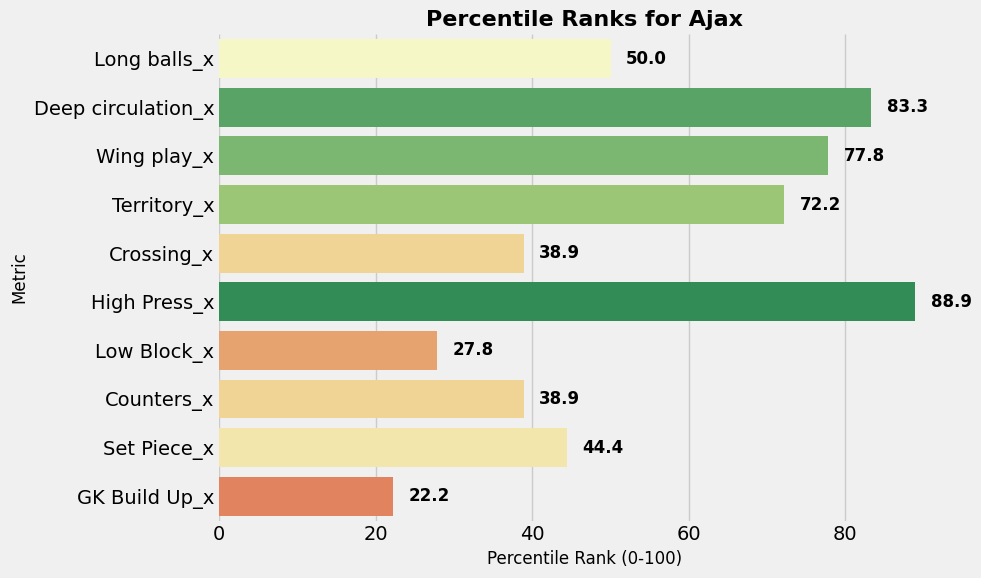

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Apply FiveThirtyEight style
plt.style.use('fivethirtyeight')

# Load the mapping file (Replace with your actual file path)
mapping_file_path = '/Users/marclambertes/Downloads/opta_club_rankings_19012025.xlsx'
mapping_df = pd.read_excel(mapping_file_path)

# Create a dictionary to map 'id' to 'team'
id_to_team = dict(zip(mapping_df['id'], mapping_df['team']))

# Assuming final_result contains the aggregated data
final_result.columns = final_result.columns.str.strip()  # Clean column names

# Merge final_result with mapping_df to add the 'team' column
final_result['team'] = final_result['contestantId'].map(id_to_team)

# Filter for Ajax team
ajax_data = final_result[final_result['team'] == 'PSV']

if not ajax_data.empty:
    # List of columns to rank
    columns_to_rank = ['Long balls_x', 'Deep circulation_x', 'Wing play_x', 'Territory_x', 
                       'Crossing_x', 'High Press_x', 'Low Block_x', 'Counters_x', 'Set Piece_x', 'GK Build Up_x']

    # Check if columns exist
    missing_columns = [col for col in columns_to_rank if col not in ajax_data.columns]
    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    else:
        # Calculate percentile ranks (scale to 0-100) across all teams
        percentile_ranks = final_result[columns_to_rank].apply(lambda x: x.rank(pct=True) * 100, axis=0)

        # Extract percentile ranks for Ajax players
        ajax_percentiles = percentile_ranks[final_result['team'] == 'AZ'].mean()  # Take mean if multiple players

        # Define a red-green color gradient based on values
        norm = plt.Normalize(0, 100)
        colors = sns.color_palette("RdYlGn", as_cmap=True)(norm(ajax_percentiles.values))

        # Create a horizontal bar plot
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = sns.barplot(x=ajax_percentiles.values, y=ajax_percentiles.index, palette=colors, ax=ax)

        # Add values at the end of bars
        for bar, value in zip(bars.patches, ajax_percentiles.values):
            ax.text(bar.get_width() + 2, bar.get_y() + bar.get_height() / 2, f"{value:.1f}", 
                    ha='left', va='center', fontsize=12, fontweight='bold')

        # Add titles and labels
        ax.set_title("Percentile Ranks for Ajax", fontsize=16, fontweight='bold')
        ax.set_xlabel('Percentile Rank (0-100)', fontsize=12)
        ax.set_ylabel('Metric', fontsize=12)

        # Remove unnecessary chart borders for a cleaner look
        sns.despine(left=True, bottom=True)

        # Show the plot
        plt.tight_layout()
        plt.show()
else:
    print("No data found for Ajax.")
